<a class="anchor" id="toc-go-back"></a>
# Assignment 3: Day-ahead scheduling from the perspective of the system operator

### Table of Contents
* [1. Loading the data](#data-loading)
* [2. Setup optimization problem](#optimziation-problem-setup)
* [3. Running the optimization model ](#run-optimization)
* [4. Can we solve the problem using machine learning?](#machine-learning)
* [5. Extra ](#extra)

First of all, we refer to the hand-in for an in-depth description of the problem formulation and the optimization problem. This notebooks focuses on implementing the model using ```Gurobipy``` and an additional part using machine learning. 

We start by loading the relevant modules.

In [83]:
from pathlib import Path

import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import gurobipy as grb

In [84]:
DATA_DIR = Path('../data')

<a class="anchor" id="data-loading"></a>
## 1. Loading the data

We initially load the data files given to us with the assignment description. This will later on be used as input to the optimization model from which we can then find the optimal values of the decision variables.

In [85]:
# Load data files from csv-files
pmax    = pd.read_csv(DATA_DIR / 'pgmax.csv')
pmin    = pd.read_csv(DATA_DIR / 'pgmin.csv')
ru      = pd.read_csv(DATA_DIR / 'ramp.csv')
UT      = pd.read_csv(DATA_DIR / 'lu.csv')
DT      = pd.read_csv(DATA_DIR / 'ld.csv')    
demand  = pd.read_csv(DATA_DIR / 'Demand.csv', sep=';')   
c_op    = pd.read_csv(DATA_DIR / 'cost_op.csv') 
c_st    = pd.read_csv(DATA_DIR / 'cost_st.csv') 
PTDF    = pd.read_csv(DATA_DIR / 'PTDF.csv', sep=';') 
busgen  = pd.read_csv(DATA_DIR / 'busgen.csv', sep=';')
busload = pd.read_csv(DATA_DIR / 'busload.csv', sep=';')
fmax    = pd.read_csv(DATA_DIR / 'fmax.csv')

# 
Hg      = pd.DataFrame(np.dot(PTDF, busgen), index=[f'Line {i+1}' for i in range(PTDF.shape[0])], columns=[f'Gen {i+1}' for i in range(busgen.shape[1])])
Hl      = pd.DataFrame(np.dot(PTDF, busload), index=[f'Line {i+1}' for i in range(PTDF.shape[0])], columns=[f'Load {i+1}' for i in range(busload.shape[1])])

# Load load profile samples
samples = pd.read_csv(DATA_DIR / 'samples.csv', header=None)

With the data set loaded, we can now define the basics underlying the optimization problem - thus, we start by defining the numerical values of the parameters.

In [86]:
N_g     = busgen.shape[1]   # the number of generator units
N_t     = demand.shape[0]   # next 24 hours
N_load  = busload.shape[1]  # the number of load buses
N_lines = PTDF.shape[0]     # the number of transmission lines

<a class="anchor" id="optimization-problem-setup"></a>
## 2. Setup optimization problem

Differences between the hand-in and the proposed formula from class:
1. start-up cost is deterministic and should not be optimized for (i.e. input parameter and not decision variable)
2. demand is additionally indexed by time for the flow constraint
3. the start-up constraint is added by specifying an on/off variable for each unit at each time, $b$.

Now, we are ready to define the decision variables of the optimization problem. These relate to the start-up status and production of generator units at each time step of the day. We additionally include a variable for denoting the on/off status. As we are given a data file for start-up costs for each generation unit, we approach the problem with the start-up cost being time-independent and consider it as an input rather than a decision variable.

Next, we add the constraints to the optimization model. Overall these concern:
1) Power balance equation, i.e. the total production must equal the total demand. Here, we add the concept of slack variable for feasibility - i.e. making sure that the problem can be solved even if in some cases the demand is not met.
2) Generation limits, ensuring that the generator units do not produce more than their maximum capacity.
3) Ramp-up and ramp-down constraints, ensuring...
4) Line technical limits, ensuring that the flow between busses does not exceed the maximum capacity of the line.
5) Minimum on/off times.
6) Start-up constraints for turning on a generator unit (i.e. the unit must be off in the previous time step).

Lastly, we define the objective function for the optimization problem. This is defined as minimizing the total cost - i.e. production cost and start-up cost. In this case, we assume deterministic start-up costs for each generator unit - in other words, we assume that they are time-independent.

These three steps have been implemented in a wrapper object related to the 118-bus system, namely the ```BUS118```-class defined below.

In [280]:

import gurobipy as grb
from tqdm import tqdm

class BUS118:
    
    def __init__(self, 
        N_g, N_t, N_load, N_lines, 
        demand,
        pmin, pmax,
        Hg, Hl, fmax,
        UT, DT, ru,
        c_op, c_st,
    ):
        
        # Define numerical parameters
        self.N_g        = N_g
        self.N_t        = N_t
        self.N_load     = N_load
        self.N_lines    = N_lines

        # Define input data
        self.demand     = demand
        self.pmin       = pmin
        self.pmax       = pmax
        self.fmax       = fmax
        self.UT         = UT
        self.DT         = DT
        self.ru         = ru
        self.c_op       = c_op
        self.c_st       = c_st
        self.Hg         = Hg
        self.Hl         = Hl

    def define_decision_variables(self):
        # Add variables for each generator unit at each time step for specifying on/off and start-up status
        self.b      = self.model.addVars(self.N_g, self.N_t, vtype=grb.GRB.BINARY, name='b')
        self.u      = self.model.addVars(self.N_g, self.N_t, vtype=grb.GRB.BINARY, name='u')
        
        # Add variable denoting the power output of each generator unit at each time step
        self.p      = self.model.addVars(self.N_g, self.N_t, vtype=grb.GRB.CONTINUOUS, name='p')

        # We add slack variables for ensuring feasability of the power balance equations
        self.eps    = self.model.addVars(self.N_t, 1, vtype=grb.GRB.CONTINUOUS, name='eps')
        self.delta  = self.model.addVars(self.N_t, 1, vtype=grb.GRB.CONTINUOUS, name='delta')

        # Make variable updates effective
        self.model.update()
    
    def define_constraints(self, load_profile):
        
        self.demand_profile = (self.demand * load_profile)

        for t in tqdm(range(self.N_t), desc='Adding constraints...'):
            ### POWER BALANCE EQUATION ###
            # Add power balance constraints for each time step
            self.model.addConstr(grb.quicksum(self.p[g_n, t] for g_n in range(self.N_g)) == grb.quicksum(self.demand_profile.iloc[t, n] for n in range(self.N_load)) + self.eps[t, 0] - self.delta[t, 0], name=f'power_balance[{t}]')
            
            # Add positive constraints for the slack variables
            self.model.addConstr(self.eps[t, 0] >= 0)
            self.model.addConstr(self.delta[t, 0] >= 0)

            for g in range(self.N_g):
                
                ### GENERATION LIMITS ###
                self.model.addConstr(self.b[g, t] * self.pmin.iloc[g, 0] <= self.p[g, t], name=f'generation_limit[{g},{t}]')
                self.model.addConstr(self.b[g, t] * self.pmax.iloc[g, 0] >= self.p[g, t], name=f'generation_limit[{g},{t}]')
                
                if t >= 1:
                    ### GENERATOR ON/OFF AND START-UP STATUS ###
                    self.model.addConstr(self.u[g, t] >= self.b[g, t] - self.b[g, t-1], name=f'start_up_constraint[{g},{t}]')

                    ### RAMPING CONSTRAINTS ###
                    self.model.addConstr(self.p[g, t] - self.p[g, t-1] <= self.ru.iloc[g, 0], name=f'ramping_up[{g},{t}]')
                    self.model.addConstr(self.p[g, t-1] - self.p[g, t] <= self.ru.iloc[g, 0], name=f'ramping_down[{g},{t}]')

                    ### MINIMUM ON TIME ###
                    min_on_time_generator = min(self.UT.iloc[g, 0] + t - 1, self.N_t)
                    for tau in range(t, min_on_time_generator):
                        self.model.addConstr(-self.b[g, t-1] + self.b[g, t] - self.b[g, tau] <= 0, name=f'min_on_time_constraint[{g},{t},{tau}]')
                    
                    ### MINIMUM OFF TIME ###
                    min_off_time_generator = min(self.DT.iloc[g, 0] + t - 1, self.N_t)
                    for tau in range(t, min_off_time_generator):
                        self.model.addConstr(self.b[g, t-1] - self.b[g, t] + self.b[g, tau] <= 1, name=f'min_off_time_constraint[{g},{t},{tau}]')
                                
            ### LINE FLOW LIMITS ###
            for l in range(self.N_lines):
                line_expr1  = grb.quicksum(self.Hg.iloc[l, g_n] * self.p[g_n, t] for g_n in range(self.N_g)) 
                line_expr2  = grb.quicksum(self.Hl.iloc[l, n] * self.demand_profile.iloc[t, n] for n in range(self.N_load))
                line_expr   = line_expr1 - line_expr2 - self.eps[t, 0] + self.delta[t, 0]
                                
                # LHS
                self.model.addConstr(line_expr <= self.fmax.iloc[l].item(), name=f'pos_line_flow_limit[{l},{t}]')
                # RHS
                self.model.addConstr(-self.fmax.iloc[l].item() <= line_expr, name=f'neg_line_flow_limit[{l},{t}]')

        self.model.update()
    
    def define_objective(self, M: int = 1):
        # Set minimization objective function
        minimum_objective   = grb.quicksum(self.c_op.iloc[g, 0] * self.p[g, t] + self.c_st.iloc[g, 0] * self.u[g, t] for g in range(self.N_g) for t in range(self.N_t))
        # Set slack objective function
        slack_objective     = M * grb.quicksum(self.eps[t, 0] + self.delta[t, 0] for t in range(self.N_t))

        # Set objective function
        self.model.setObjective(sense=grb.GRB.MINIMIZE, expr=minimum_objective + slack_objective)
        self.model.update()

    def setup_model(self, load_profile, M: int = 1000):
        # Set up optimization model
        self.model = grb.Model()
        self.define_decision_variables()
        self.define_constraints(load_profile)
        self.define_objective(M=M)

    def optimize(self, load_profile, M: int = 1000):
        # Initialize model
        self.setup_model(load_profile, M)
        # Run optimization
        return self.model.optimize()

<a class="anchor" id="run-optimization"></a>
## 3. Running the optimization model

For being able to run experiments, the optimization model has been collected in an object - namely, the ```BUS118```-class. 

In [283]:

import gurobipy as grb
from tqdm import tqdm
import numpy as np

class BUS118:
    
    def __init__(self, 
        N_g, N_t, N_load, N_lines, 
        demand,
        pmin, pmax,
        Hg, Hl, fmax,
        UT, DT, ru,
        c_op, c_st,
    ):
        
        # Define numerical parameters
        self.N_g        = N_g
        self.N_t        = N_t
        self.N_load     = N_load
        self.N_lines    = N_lines

        # Define input data
        self.demand     = demand
        self.pmin       = pmin
        self.pmax       = pmax
        self.fmax       = fmax
        self.UT         = UT
        self.DT         = DT
        self.ru         = ru
        self.c_op       = c_op
        self.c_st       = c_st
        self.Hg         = Hg
        self.Hl         = Hl

    def define_decision_variables(self):
        # Add variables for each generator unit at each time step for specifying on/off and start-up status
        self.b      = self.model.addVars(self.N_g, self.N_t, vtype=grb.GRB.BINARY, name='b')
        self.u      = self.model.addVars(self.N_g, self.N_t, vtype=grb.GRB.BINARY, name='u')
        
        # Add variable denoting the power output of each generator unit at each time step
        self.p      = self.model.addVars(self.N_g, self.N_t, vtype=grb.GRB.CONTINUOUS, name='p')

        # We add slack variables for ensuring feasability of the power balance equations
        self.eps    = self.model.addVars(self.N_t, 1, vtype=grb.GRB.CONTINUOUS, name='eps')
        self.delta  = self.model.addVars(self.N_t, 1, vtype=grb.GRB.CONTINUOUS, name='delta')

        # Make variable updates effective
        self.model.update()
    
    def define_constraints(self, load_profile):
        
        self.demand_profile = (self.demand * load_profile)

        pos_line_constraints, pos_constraint_names = [], []
        neg_line_constraints, neg_constraint_names = [], []
        
        for t in tqdm(range(self.N_t), desc='Adding constraints...'):
            ### POWER BALANCE EQUATION ###
            # Add power balance constraints for each time step
            self.model.addConstr(grb.quicksum(self.p[g_n, t] for g_n in range(self.N_g)) == grb.quicksum(self.demand_profile.iloc[t, n] for n in range(self.N_load)) + self.eps[t, 0] - self.delta[t, 0], name=f'power_balance[{t}]')
            
            # Add positive constraints for the slack variables
            self.model.addConstr(self.eps[t, 0] >= 0)
            self.model.addConstr(self.delta[t, 0] >= 0)

            for g in range(self.N_g):
                
                ### GENERATION LIMITS ###
                self.model.addConstr(self.b[g, t] * self.pmin.iloc[g, 0] <= self.p[g, t], name=f'generation_limit[{g},{t}]')
                self.model.addConstr(self.b[g, t] * self.pmax.iloc[g, 0] >= self.p[g, t], name=f'generation_limit[{g},{t}]')
                
                if t >= 1:
                    ### GENERATOR ON/OFF AND START-UP STATUS ###
                    self.model.addConstr(self.u[g, t] >= self.b[g, t] - self.b[g, t-1], name=f'start_up_constraint[{g},{t}]')

                    ### RAMPING CONSTRAINTS ###
                    self.model.addConstr(self.p[g, t] - self.p[g, t-1] <= self.ru.iloc[g, 0], name=f'ramping_up[{g},{t}]')
                    self.model.addConstr(self.p[g, t-1] - self.p[g, t] <= self.ru.iloc[g, 0], name=f'ramping_down[{g},{t}]')

                    ### MINIMUM ON TIME ###
                    min_on_time_generator = min(self.UT.iloc[g, 0] + t - 1, self.N_t)
                    for tau in range(t, min_on_time_generator):
                        self.model.addConstr(-self.b[g, t-1] + self.b[g, t] - self.b[g, tau] <= 0, name=f'min_on_time_constraint[{g},{t},{tau}]')
                    
                    ### MINIMUM OFF TIME ###
                    min_off_time_generator = min(self.DT.iloc[g, 0] + t - 1, self.N_t)
                    for tau in range(t, min_off_time_generator):
                        self.model.addConstr(self.b[g, t-1] - self.b[g, t] + self.b[g, tau] <= 1, name=f'min_off_time_constraint[{g},{t},{tau}]')
                                
            ### LINE FLOW LIMITS ###
            for l in range(self.N_lines):
                line_expr1  = grb.quicksum(self.Hg.iloc[l, g_n] * self.p[g_n, t] for g_n in range(self.N_g)) 
                line_expr2  = grb.LinExpr(np.dot(self.Hl.iloc[l, :], self.demand_profile.iloc[t, :]))
                line_expr   = line_expr1 - line_expr2 - self.eps[t, 0] + self.delta[t, 0]

                line_max = self.fmax.iloc[l].item()
                # RHS
                pos_line_constraints.append(line_expr <= line_max)
                pos_constraint_names.append(f'pos_line_flow_limit[{l},{t}]')
                # LHS
                neg_line_constraints.append(-line_max <= line_expr)
                neg_constraint_names.append(f'neg_line_flow_limit[{l},{t}]')

            # # LHS
            # self.model.addConstr(line_expr <= self.fmax.iloc[l].item(), name=f'pos_line_flow_limit[{l},{t}]')
            # # RHS
            # self.model.addConstr(-self.fmax.iloc[l].item() <= line_expr, name=f'neg_line_flow_limit[{l},{t}]')

        self.model.addConstrs(pos_line_constraints, names=pos_constraint_names)
        self.model.addConstrs(neg_line_constraints, names=neg_constraint_names)   
        self.model.update()
    
    def define_objective(self, M: int = 1):
        # Set minimization objective function
        minimum_objective   = grb.quicksum(self.c_op.iloc[g, 0] * self.p[g, t] + self.c_st.iloc[g, 0] * self.u[g, t] for g in range(self.N_g) for t in range(self.N_t))
        # Set slack objective function
        slack_objective     = M * grb.quicksum(self.eps[t, 0] + self.delta[t, 0] for t in range(self.N_t))

        # Set objective function
        self.model.setObjective(sense=grb.GRB.MINIMIZE, expr=minimum_objective + slack_objective)
        self.model.update()

    def setup_model(self, load_profile, M: int = 1000):
        # Set up optimization model
        self.model = grb.Model()
        self.define_decision_variables()
        self.define_constraints(load_profile)
        self.define_objective(M=M)

    def optimize(self, load_profile, M: int = 1000):
        # Initialize model
        self.setup_model(load_profile, M)
        # Run optimization
        return self.model.optimize()

In [284]:
system = BUS118(
    N_g=N_g, N_t=N_t, N_load=N_load, N_lines=N_lines,
    demand=demand,
    pmin=pmin, pmax=pmax,
    Hg=Hg, Hl=Hl, fmax=fmax,
    UT=UT, DT=DT, ru=ru,
    c_op=c_op, c_st=c_st,
)

In [285]:
# Select a load profile
load_profile = samples.iloc[0, :].values[np.newaxis, :] * 2

# Optimize system with specified load profile
opt = system.optimize(load_profile, M=10000)

Adding constraints...:  12%|█▎        | 3/24 [01:22<09:36, 27.46s/it]

Unexpected exception formatting exception. Falling back to standard exception



Traceback (most recent call last):
  File "c:\Users\alber\Miniconda3\envs\46765\Lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\alber\AppData\Local\Temp\ipykernel_19184\2448685492.py", line 5, in <module>
    opt = system.optimize(load_profile, M=10000)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\alber\AppData\Local\Temp\ipykernel_19184\2289035626.py", line 132, in optimize
    self.setup_model(load_profile, M)
  File "C:\Users\alber\AppData\Local\Temp\ipykernel_19184\2289035626.py", line 127, in setup_model
    self.define_constraints(load_profile)
  File "C:\Users\alber\AppData\Local\Temp\ipykernel_19184\2289035626.py", line 92, in define_constraints
    line_expr1  = grb.quicksum(self.Hg.iloc[l, g_n] * self.p[g_n, t] for g_n in range(self.N_g))
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "src\gurobipy\gur

In [209]:
# Prepare data format for results
on_off      = -1 * np.ones((system.N_g, system.N_t))
start_up    = -1 * np.ones((system.N_g, system.N_t))
power       = -1 * np.ones((system.N_g, system.N_t))
cost        = -1 * np.ones((system.N_g, system.N_t))
raw_op      = -1 * np.ones((system.N_g, system.N_t))
raw_st      = -1 * np.ones((system.N_g, system.N_t))
delta       = -1 * np.ones((system.N_t, 1))
eps         = -1 * np.ones((system.N_t, 1))

# Extract results
for t in range(24):
    for g in range(N_g):
        # Generator dependent results
        on_off[g, t]    = system.b[g, t].x
        start_up[g, t]  = system.u[g, t].x
        power[g, t]     = system.p[g, t].x
        cost[g, t]      = system.c_op.iloc[g, 0] * system.p[g, t].x + system.c_st.iloc[g, 0] * system.u[g, t].x
        raw_op[g, t]    = system.c_op.iloc[g, 0] 
        raw_st[g, t]    = system.c_st.iloc[g, 0]

    # Slack variables
    eps[t, 0]   = system.eps[t, 0].x
    delta[t, 0] = system.delta[t, 0].x

# For some reason, some zeros get a minus in front - taking the absolute value does not change the value, only the visual outline of the matrix
on_off      = pd.DataFrame(abs(on_off),     columns=[f'Hour {i}' for i in range(1, system.N_t+1)], index=[f'Gen {i}' for i in range(1, system.N_g+1)])
start_up    = pd.DataFrame(abs(start_up),   columns=[f'Hour {i}' for i in range(1, system.N_t+1)], index=[f'Gen {i}' for i in range(1, system.N_g+1)])
power       = pd.DataFrame(power,           columns=[f'Hour {i}' for i in range(1, system.N_t+1)], index=[f'Gen {i}' for i in range(1, system.N_g+1)])
cost        = pd.DataFrame(cost,            columns=[f'Hour {i}' for i in range(1, system.N_t+1)], index=[f'Gen {i}' for i in range(1, system.N_g+1)])
raw_op      = pd.DataFrame(raw_op,          columns=[f'Hour {i}' for i in range(1, system.N_t+1)], index=[f'Gen {i}' for i in range(1, system.N_g+1)]).mean(axis=1).reset_index().set_index('index').rename(columns={0: 'Raw cost'})
raw_st      = pd.DataFrame(raw_st,          columns=[f'Hour {i}' for i in range(1, system.N_t+1)], index=[f'Gen {i}' for i in range(1, system.N_g+1)]).mean(axis=1).reset_index().set_index('index').rename(columns={0: 'Raw cost'})

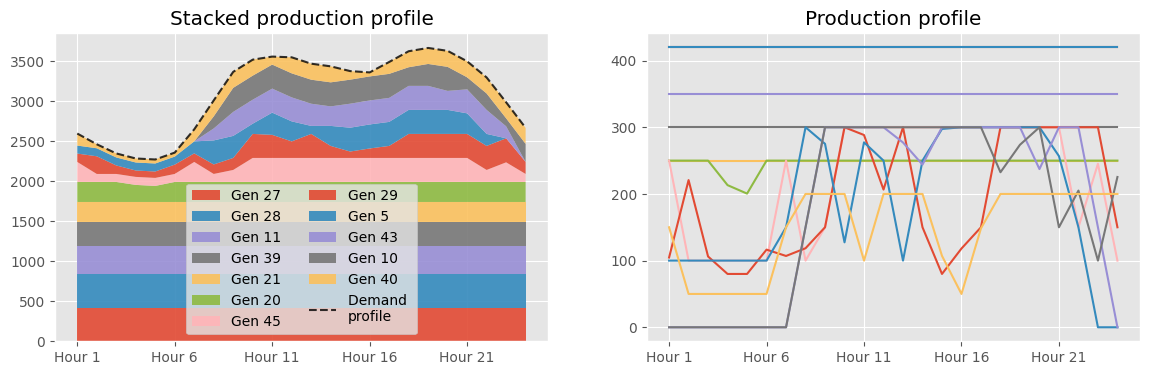

In [210]:
generators_turned_on = on_off.sum(axis=1) != 0

system.pmax['index'] = [f'Gen {i}' for i in range(1, system.N_g+1)]
system.pmax = system.pmax.set_index('index')

system.pmin['index'] = [f'Gen {i}' for i in range(1, system.N_g+1)]
system.pmin = system.pmin.set_index('index')

# Check if power balance equation is satisfied 
power_balance = pd.DataFrame(
    [system.demand_profile.sum(axis=1).values, power.sum(axis=0).values, eps.flatten(), delta.flatten(), (eps + delta).flatten()], 
    index=['demand', 'power', 'eps', 'delta', 'slack_sum'
]).T
assert np.allclose(power_balance['demand'], power_balance[['power', 'eps', 'delta']].sum(axis=1)), 'Power balance equation not satisfied !'

power['total_production'] = power[generators_turned_on].cumsum(axis=1)['Hour 24']


fig, axs = plt.subplots(1, 2, figsize=(14, 4), sharey=False, sharex=False)
axs[0].stackplot(
    np.arange(1, 25), 
    power[generators_turned_on].sort_values(by='total_production', ascending=False).drop(columns='total_production'), 
    labels=power[generators_turned_on].sort_values(by='total_production', ascending=False).drop(columns='total_production').index,
    alpha=0.9,
)
axs[0].plot(np.arange(1,25), power_balance['demand'], color='k', ls='--', alpha=0.8, label='Demand \nprofile')
axs[0].set_title('Stacked production profile')
axs[0].set_xticks(np.arange(1, 25)[::5], [f'Hour {i+1}' for i in range(24)][::5])
axs[0].legend(loc='lower center', ncols=2)

power[generators_turned_on].sort_values(by='total_production', ascending=False).drop(columns='total_production').T.plot(title='Production profile', ax=axs[1], legend=False)

plt.show()

C:\Users\alber\AppData\Local\Temp\ipykernel_19184\3329453753.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  colors                  = ['green' if gen_ in generators_turned_on[active_].index else 'red' for gen_ in c_op_['Generator unit']]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\alber\AppData\Local\Temp\ipykernel_19184\3329453753.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axs[0].set_xticks(np.arange(len(c_op_)), c_op_['Generator unit'].apply(lambda x: x if x in generators_turned_

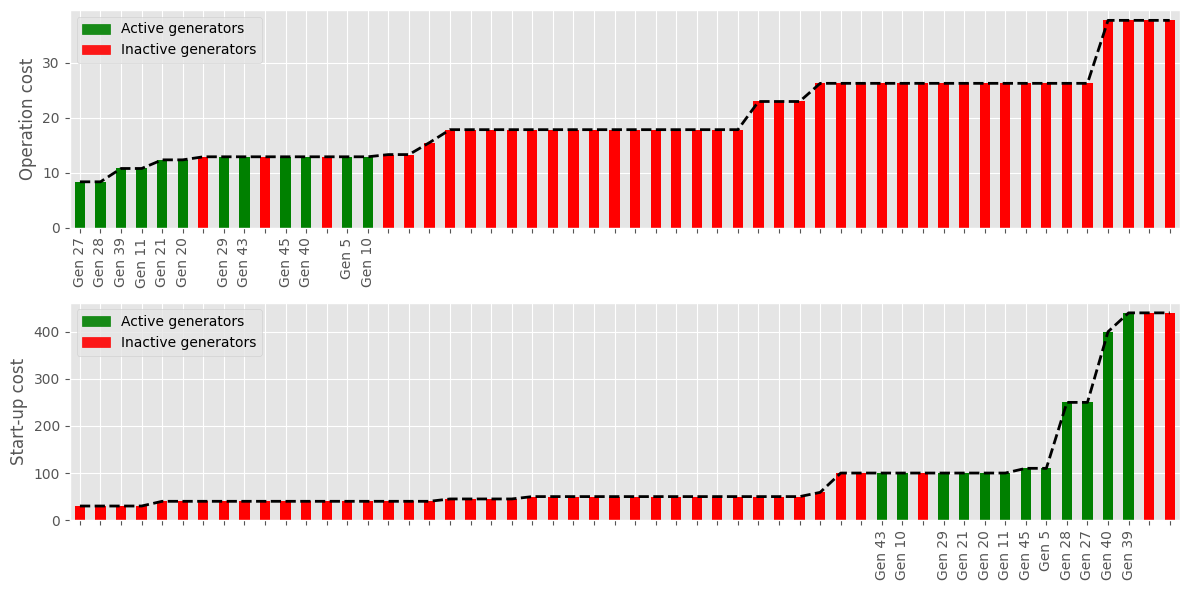

In [211]:
c_op_   = c_op.copy()
c_st_   = c_st.copy()

active_ = np.where(generators_turned_on == 1)[0]

handles = [plt.Rectangle((0, 0), 1, 1, color='green', alpha=0.9),
           plt.Rectangle((0, 0), 1, 1, color='red', alpha=0.9)]

fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharey='row', sharex=False)
### PLOT OPERATION COST ###
c_op_['Generator unit'] = power.index
c_op_                   = c_op_.sort_values(by='cost_op', ascending=True)
colors                  = ['green' if gen_ in generators_turned_on[active_].index else 'red' for gen_ in c_op_['Generator unit']]

c_op_.plot(x='Generator unit', y='cost_op', kind='line', color='k', linewidth=2, ls='--', legend=False, ax=axs[0])
c_op_.plot(x='Generator unit', y='cost_op', kind='bar', color=colors, legend=False, ax=axs[0])
plt.legend(loc='upper right')
axs[0].set_xticks(np.arange(len(c_op_)), c_op_['Generator unit'].apply(lambda x: x if x in generators_turned_on[active_] else '').values)
axs[0].legend(handles, ['Active generators', 'Inactive generators'], loc='upper left')
axs[0].set_ylabel('Operation cost')
axs[0].set_xlabel('')

### PLOT START-UP COST ###
c_st_['Generator unit']  = power.index
c_st_                    = c_st_.sort_values(by='cost_st', ascending=True)
colors                  = ['green' if gen_ in generators_turned_on[active_].index else 'red' for gen_ in c_st_['Generator unit']]

c_st_.plot(x='Generator unit', y='cost_st', kind='line', color='k', linewidth=2, ls='--', legend=False, ax=axs[1])
c_st_.plot(x='Generator unit', y='cost_st', kind='bar', color=colors, legend=False, ax=axs[1])
axs[1].set_xticks(np.arange(len(c_st_)), c_st_['Generator unit'].apply(lambda x: x if x in generators_turned_on[active_] else '').values)
axs[1].legend(handles, ['Active generators', 'Inactive generators'], loc='upper left')
axs[1].set_ylabel('Start-up cost')
axs[1].set_xlabel('')

plt.tight_layout()
plt.show()

In [212]:
temp_                   = pmin.iloc[active_].merge(pmax.iloc[active_], on='index').reset_index(drop=True)
temp_                   = pd.concat([temp_, UT.iloc[active_].reset_index(drop=True), DT.iloc[active_].reset_index(drop=True)], axis=1)
temp_                   = pd.concat([temp_, c_st.iloc[active_].reset_index(drop=True), c_op.iloc[active_].reset_index(drop=True)], axis=1)
temp_                   = temp_.set_index('index')
temp_

,pmin,pmax,lu,ld,cost_st,cost_op
index,,,,,,
Gen 5,100,300,8,8,110,12.8875
Gen 10,100,300,8,8,100,12.8875
Gen 11,100,350,8,8,100,10.7600
Gen 20,50,250,8,8,100,12.3299
Gen 21,50,250,8,8,100,12.3299
Gen 27,100,420,10,10,250,8.3391
Gen 28,100,420,10,10,250,8.3391
Gen 29,80,300,8,8,100,12.8875
Gen 39,100,300,8,8,440,10.7600


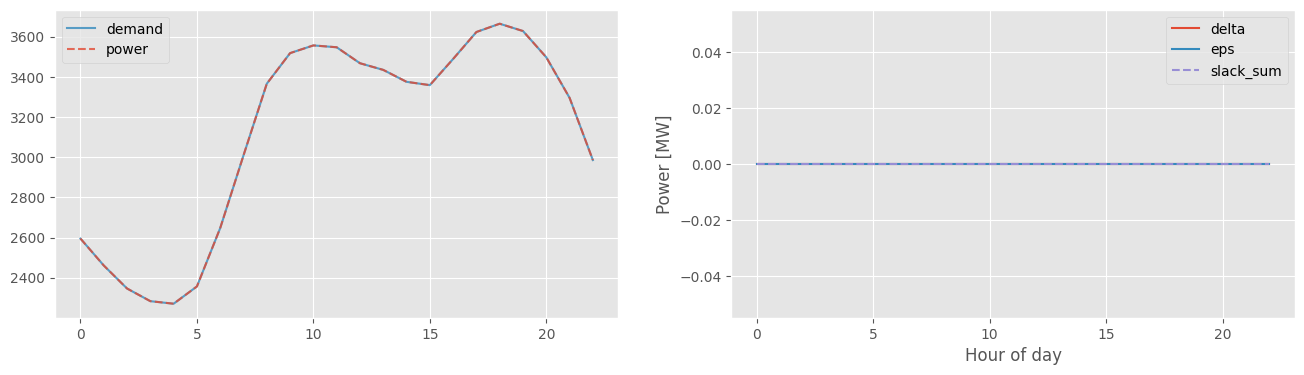

In [213]:
fig, axs = plt.subplots(1, 2, figsize=(16, 4)) 
power_balance[:-1].plot(y=['demand'], color='C1', ls='-', alpha=0.8, ax=axs[0])
power_balance[:-1].plot(y=['power'], color='C0', ls='--', alpha=0.8, ax=axs[0])
power_balance[:-1].plot(y=['delta', 'eps'],      ax=axs[1])
power_balance[:-1].plot(y='slack_sum', ls='--',  ax=axs[1])
plt.xlabel('Hour of day')
plt.ylabel('Power [MW]')
plt.show()

Total cost of the system:  799030.4225108316


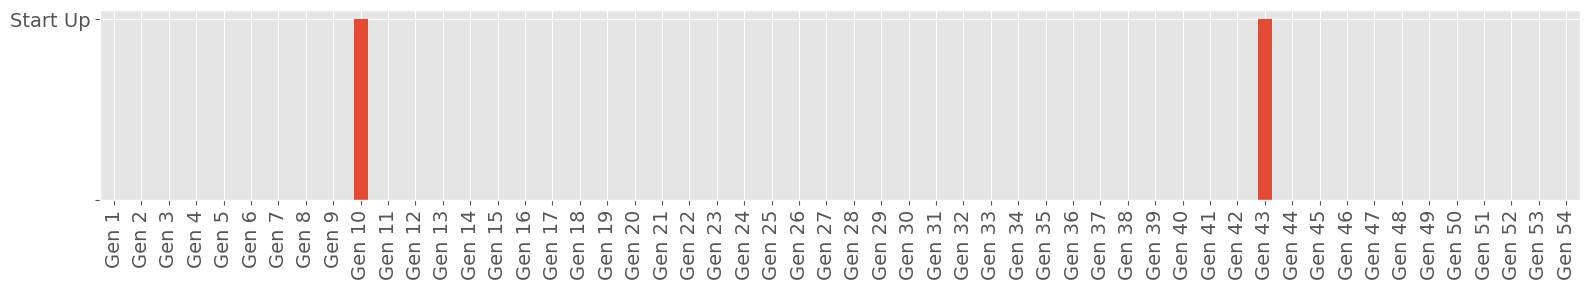

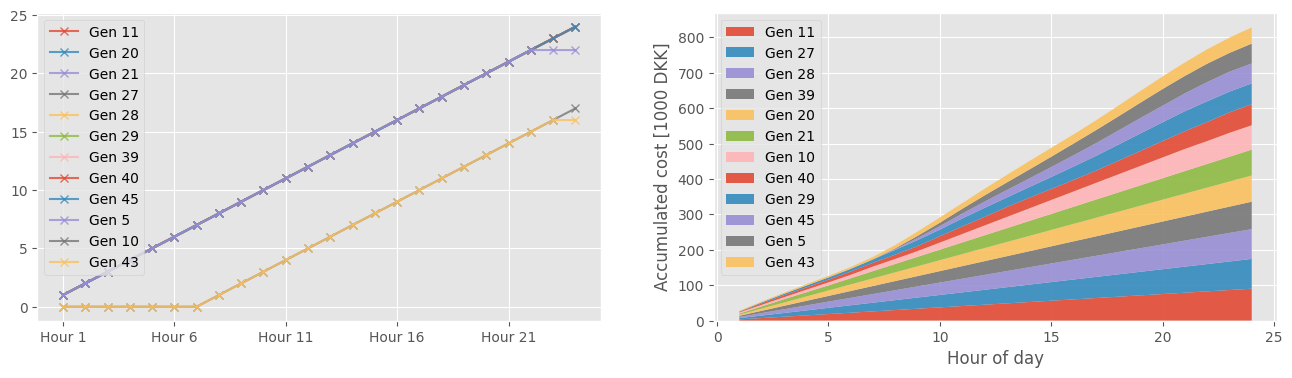

,Hour 6,Hour 7,Hour 8,Hour 9,Hour 10,Hour 11,Hour 12,Hour 13,Hour 14,Hour 15,Hour 16,Hour 17,Hour 18,Hour 19,Hour 20,Hour 21,Hour 22,Hour 23,Hour 24
Gen 10,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Gen 43,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [214]:
print("Total cost of the system: ", sum(cost.iloc[:, :-1].values.flatten()))

# Shwo start up status
start_up.sum(axis=1).plot(kind='bar', figsize=(16, 3))
plt.yticks([0, 1], ['', 'Start Up'], fontsize=14)
plt.xticks(fontsize=14)
plt.tight_layout()
plt.show()

### Create production cost curves
fig, axs = plt.subplots(1, 2, figsize=(16, 4))
generators_turned_on = on_off.sum(axis=1) != 0

# Visalize when the generators are turned on
on_off[generators_turned_on].cumsum(axis=1).sort_values(by='Hour 24', ascending=False).T.plot(ax=axs[0], ls='-', marker='x', alpha=0.8)

# Visualize the cost of the system for each turned on generator
axs[1].stackplot(
    np.arange(1, 25), 
    cost.iloc[:, :][generators_turned_on].cumsum(axis=1).sort_values(by='Hour 24', ascending=False) / 1000, 
    labels=cost.iloc[:, :][generators_turned_on].sort_values(by='Hour 24', ascending=False).index,
    alpha=0.9,
)
axs[1].legend(loc='upper left')
axs[1].set_xlabel('Hour of day')
axs[1].set_ylabel('Accumulated cost [1000 DKK]')
plt.show()

start_up[start_up.sum(axis=1) != 0].iloc[:, 5:]

### Finding active constraints

In [261]:
constraints = pd.DataFrame([{
    'constr_type': c.ConstrName.split('[')[0] if '[' in c.ConstrName else c.ConstrName, 
    'constr_level': '[' + c.ConstrName.split('[')[1] if '[' in c.ConstrName else '-', 
    'constraint_slack': c.Slack, 
    'rhs': c.getAttr('rhs')
} for c in system.model.getConstrs()])

grouped_constraints = {}
for name in tqdm(constraints['constr_type'].unique()):
    grouped_constraints[name] = constraints.query('constr_type == @name').reset_index(drop=True)

100%|██████████| 57/57 [00:00<00:00, 464.24it/s]


In [262]:
pos_line_flow_limits            = grouped_constraints['pos_line_flow_limit']
pos_line_flow_limits['l']       = pos_line_flow_limits['constr_level'].progress_apply(lambda x: int(x.strip('[').strip(']').split(',')[0]))
pos_line_flow_limits['t']       = pos_line_flow_limits['constr_level'].progress_apply(lambda x: int(x.strip('[').strip(']').split(',')[1]))
pos_line_flow_limits['active']  = (abs(pos_line_flow_limits['constraint_slack']) < 1e-3).astype(int)

# Extract as dataframe
pos_active_lines                = pd.pivot_table(pos_line_flow_limits, index='t', columns='l', values='active', aggfunc='sum')
pos_active_lines.columns        = [f'Line {i+1}' for i in range(system.N_lines)]
pos_active_lines.index          = [f'Hour {i+1}' for i in range(system.N_t)]

print((abs(pos_line_flow_limits.constraint_slack) < 1e-3).sum())
pos_line_flow_limits.head()

100%|██████████| 4464/4464 [00:00<00:00, 481258.79it/s]

1


,constr_type,constr_level,constraint_slack,rhs,l,t,active
0,pos_line_flow_limit,"[0,0]",192.401558,189.149738,0,0,0
1,pos_line_flow_limit,"[1,0]",196.063537,199.315357,1,0,0
2,pos_line_flow_limit,"[2,0]",527.846249,537.488549,2,0,0
3,pos_line_flow_limit,"[3,0]",204.213755,211.609652,3,0,0
4,pos_line_flow_limit,"[4,0]",149.737665,136.301943,4,0,0


In [258]:
neg_line_flow_limits            = grouped_constraints['neg_line_flow_limit']
neg_line_flow_limits['l']       = neg_line_flow_limits['constr_level'].progress_apply(lambda x: int(x.strip('[').strip(']').split(',')[0]))
neg_line_flow_limits['t']       = neg_line_flow_limits['constr_level'].progress_apply(lambda x: int(x.strip('[').strip(']').split(',')[1]))
neg_line_flow_limits['active']  = (abs(neg_line_flow_limits['constraint_slack']) < 1e-3).astype(int)

# Extract as dataframe
neg_active_lines = pd.pivot_table(neg_line_flow_limits, index='t', columns='l', values='active', aggfunc='sum')
neg_active_lines.columns = [f'Line {i+1}' for i in range(system.N_lines)]
neg_active_lines.index = [f'Hour {i+1}' for i in range(system.N_t)]

print((abs(neg_line_flow_limits.constraint_slack) < 1e-3).sum())
neg_line_flow_limits.head()

100%|██████████| 4464/4464 [00:00<00:00, 890401.99it/s]

0


,constr_type,constr_level,constraint_slack,rhs,l,t,active
0,neg_line_flow_limit,"[0,0]",-157.598442,-160.850262,0,0,0
1,neg_line_flow_limit,"[1,0]",-153.936463,-150.684643,1,0,0
2,neg_line_flow_limit,"[2,0]",-472.153751,-462.511451,2,0,0
3,neg_line_flow_limit,"[3,0]",-145.786245,-138.390348,3,0,0
4,neg_line_flow_limit,"[4,0]",-200.262335,-213.698057,4,0,0


In [259]:
slack_line_vals_neg = neg_line_flow_limits['constraint_slack'] - neg_line_flow_limits['rhs']
slack_line_vals_pos = pos_line_flow_limits['constraint_slack'] - pos_line_flow_limits['rhs']

np.allclose(abs(slack_line_vals_pos), abs(slack_line_vals_neg))

True

<a class="anchor" id="machine-learning"></a>
## 4. Can we solve the problem using machine learning?

In the script ```src/assignment3/run_optimization.py``` the optimization model was run for a large variety of demand load profiles. In order to create a data set for the machine learning problem, the binary variables and line flow constraints were saved.

In [4]:
import glob
from pathlib import Path
import pandas as pd

In [5]:
DATA_DIR = Path('../data')

In [6]:
active_lines_files      = sorted(glob.glob((DATA_DIR / 'Processed/active_*.csv').as_posix()), key=lambda x: len(x))
binary_variables_files  = sorted(glob.glob((DATA_DIR / 'Processed/binary_*.csv').as_posix()), key=lambda x: len(x))

In [97]:
### FIX INACCURATE BINARY FORMAT ###
# import os

# correct_format = pd.read_csv(binary_variables_files[0], index_col=0)
# correct_format.to_csv(DATA_DIR / f'new_processed/{binary_variables_files[0].split(os.sep)[1]}')

# temp            = pd.read_csv(binary_variables_files[1], header=None, index_col=None)
# temp.columns    = correct_format.columns
# temp.index      = correct_format.index
# temp.to_csv(DATA_DIR / f'new_processed/{binary_variables_files[1].split(os.sep)[1]}')

# temp            = pd.read_csv(binary_variables_files[2], header=None, index_col=None)
# temp.columns    = correct_format.columns
# temp.index      = correct_format.index
# temp.to_csv(DATA_DIR / f'new_processed/{binary_variables_files[2].split(os.sep)[1]}')

# temp            = pd.read_csv(binary_variables_files[4], header=None, index_col=None)
# temp.columns    = correct_format.columns
# temp.index      = correct_format.index
# temp.to_csv(DATA_DIR / f'new_processed/{binary_variables_files[4].split(os.sep)[1]}')

In [40]:
temp            = pd.read_csv(active_lines_files[0], index_col=0)
pos_temp = temp.iloc[:, :186]
pos_temp.columns = [f'Line {i+1}' for i in range(186)]

neg_temp = temp.iloc[:, 186:]
neg_temp.columns =  [f'Line {i+1}' for i in range(186)]

In [55]:
fmax = pd.read_csv(DATA_DIR / 'fmax.csv').T
fmax.columns =  [f'Line {i+1}' for i in range(186)]
fmax = fmax.T

In [69]:
from tqdm import tqdm

In [70]:
tqdm.pandas()

In [80]:
active_ = pos_temp.T.progress_apply(lambda x: abs(x.values - fmax.values.flatten()) <= 10).T

100%|██████████| 12000/12000 [00:00<00:00, 17983.84it/s]


In [81]:
active_.sum(axis=0).sum()

819

In [51]:
fmax.T == pos_temp.iloc[0]

ValueError: Operands are not aligned. Do `left, right = left.align(right, axis=1, copy=False)` before operating.

In [36]:
pos_temp.apply(lambda x: x == fmax.values)

ValueError: ('Lengths must match to compare', (12000,), (186, 1))

In [27]:
import numpy as np

In [32]:
pos_temp.equals(fmax, axis=0)


TypeError: NDFrame.equals() got an unexpected keyword argument 'axis'

In [28]:
pos_temp == fmax.T[:, np.newaxis]

KeyError: (slice(None, None, None), None)

In [24]:
temporary   = pd.read_csv(binary_variables_files[0], index_col=0)
df_on_off   = temporary.iloc[:, :54]
df_start_up = temporary.iloc[:, 54:]

for filename in binary_variables_files[1:]:
    temporary   = pd.read_csv(filename, index_col=0)
    df_on_off   = pd.concat([df_on_off, temporary.iloc[:, :54]], axis=1)
    df_start_up = pd.concat([df_start_up, temporary.iloc[:, 54:]], axis=1)

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [ ]:
# OUTPUT: binary generator on/off status
# OUTPUT: active constraints (on transmission lines)

# INPUT: load profile
# INPUT: demand
# INPUT: time (hours)
# INPUT: ramping up/down
# INPUT: minimum on/off time
# INPUT: cost of operation
# INPUT: cost of start-up

In [ ]:
# AUC curve
# heatmap

<a class="anchor" id="extra"></a>
## 5. Extra